# 15wk-1: MCMC (3)

최규빈  
2023-06-01

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import copy

# 강의영상

> youtube:
> <https://youtube.com/playlist?list=PLQqh36zP38-z-M7HO1xUnq2z5lK8aq1_a>

# imports

# 모티브

`-` 축구기사

-   손흥민: <https://www.hani.co.kr/arti/sports/soccer/1093315.html>

`-` 16강진출 경우의 수

-   16강 가능할까? :
    <https://www.fifa.com/fifaplus/ko/articles/number-of-cases-korea-goes-to-round-of-16>

`-` 통계, 데이터과학

-   생략

# 문제소개

`-` 3개의 문서가 있으며 각 문서에는 아래와 같이 2개의 단어가 있는
데이터를 고려하자.

In [8]:
D = {
    'doc1':['손흥민','골'],
    'doc2':['골','확률'],
    'doc3':['확률','데이터과학']
}
D

{'doc1': ['손흥민', '골'], 'doc2': ['골', '확률'], 'doc3': ['확률', '데이터과학']}

-   여기에서 $D$는 문서들의 집합, 즉 코퍼스를 의미한다.

`-` 데이터설명

***토픽***

-   토픽0 = 축구 : ‘골’, ‘손흥민’ 와 같은 단어가 쓰임.
-   토픽1 = 통계 : ‘데이터과학’, ‘확률’ 와 같은 단어가 쓰임.

***문서***

-   doc0은 축구를 주제로 쓰여진 글인듯 하다.
-   doc2은 데이터과학을 주제로 쓰여진 글인듯 하다.
-   doc1는 축구와 데이터과학이 혼합된 주제인듯 하다.

`-` 원하는 것1: 문서별로 토픽이 얼마나 들어있는지 알고싶다.

-   즉 $D$를 입력으로 넣으면 아래와 같은 $\theta$ 가 나오면 좋겠음

In [9]:
θ = {
    'doc1':[1,1],
    'doc2':[1,2],
    'doc3':[2,2]
}
θ

{'doc1': [1, 1], 'doc2': [1, 2], 'doc3': [2, 2]}

Table 1: 우리가 원하는것 (1)

`-` 원하는것1에 대한 아쉬움

-   그런데 생각해보니까 “손흥민”이라는 단어는 완전 축구단어
-   “골”이라는 단어는 가끔 데이터과학과 섞일 수 있는 단어
-   “손흥민”이라는 단어는 축구토픽에서 나올 확률이 90퍼 이상, “골”은
    축구토픽에서 나올 확률이 80퍼정도일수도 있잖음?

`-` 원하는 것2: 특정한 하나의 ${\boldsymbol \theta}$ 값이 아니라 아래와
같이

$${\boldsymbol \theta} \sim {\boldsymbol \pi}$$

${\boldsymbol \theta}$를 뽑아낼 수 있는 분포 ${\boldsymbol \pi}$를
알아내는게 더 좋지 않을까?

Table 2: 우리가 원하는것 (2)

`-` 어려운점: 현재 ${\boldsymbol \pi}$ (=${\boldsymbol \theta}$의 pmf)
의 수식을 알 수 없어서 직접 뽑기 어렵다.

# 가능한 해결책: 아이디어 단계

`-` 이론적인 근거는 아직 설명하기 어렵지만 되게 그럴듯한 해결책이
있습니다.

`-` 문제의 단순화:

-   결국 길이가 6인 랜덤벡터
    ${\boldsymbol \theta}=(\theta[0],\dots,\theta[5])$ 를 뽑는 일이다.

## ***단계1: 아무값이나 넣어서 ${\boldsymbol \theta}_0$를 초기화한다.***

`-` ${\boldsymbol \theta}_0=(\theta_0[0],\dots,\theta_0[5])$를
아무값이나 셋팅

In [10]:
θ = {
    'doc1':[2,1],
    'doc2':[1,2],
    'doc3':[2,1]
}

-   ${\boldsymbol \theta}_0 = [2,1,1,2,2,1]$ 이라고 생각하자.

`-` 임의의 초기값이 셋팅된 상황은 아래와 같다.

Table 3: 초기상태요약

## ***단계2: ${\boldsymbol \theta}_0[0], {\boldsymbol \theta}_0[1] \cdots, {\boldsymbol \theta}_0[5]$ 을 순서대로 샘플링***

***`-` 예비개념: MCMC에서 베타분포를 뽑았던 예제로 돌아가보자***

1.  임의의 초기값 $x$ 생성
2.  새로운 값으로 $y$를 고려 (추천받을 수도 있고 그냥 고려할수도 있음)
3.  $x$가 그럴듯한지, $y$가 그럴듯한지 판단하고 $x'$의 값은 어떠한확률로
    $x,y$ 중에서 선택

`-` 전략: 그동안 pmf 혹은 pdf의 정보가 필요했던 것은 “그럴듯한 정도” 를
판단할 기준을 얻기 위해서였다. 그런데 만약, “그럴듯한 정도”를 판단하는
기준을 pmf, pdf 로 정하지 않는다면? pmf 혹은 pdf 가 필요하지 않다.

### stage0: ***${\boldsymbol \theta}_0[0]$을 sampling***

`-` 현재상태

-   빨간색/볼드: 지금 focus하는 것

Table 4: $t=0$, $d={\tt doc1}$, $w={\tt 손흥민}$

`-` $\theta_0[0]$이 토픽1에서 뽑혓다고 보는게 타당한지 토픽1에서
뽑혔다고 보는게 타당하지 아래와 같이 따져보자.

-   토픽1의 타당성: (`doc1`에 토픽1이 포함된 비율) $\times$ (토픽1에서
    `손흥민`이라는 단어가 포함된 비율) = 1 $\times$ 0
-   토픽2의 타당성: (`doc1`에 토픽2가 포함된 비율) $\times$ (토픽2에서
    `손흥민`이라는 단어가 포함된 비율) = 0 $\times$ 0

> 둘 다 $0$ 이라서 비긴거야?? 그런데 그래도 토픽1가 그나마 타당한거아냐?

`-` 수정된 타당성

-   토픽1의 타당성: (`doc1`에 토픽1이 포함된 비율) $\times$ (토픽1에서
    `손흥민`이라는 단어가 포함된 비율) = 1 $\times$ 0.001
-   토픽2의 타당성: (`doc1`에 토픽2가 포함된 비율) $\times$ (토픽2에서
    `손흥민`이라는 단어가 포함된 비율) = 0.001 $\times$ 0.001

> $\theta_0[0]$의 생각: 나는 토픽1인듯해

`-` 업데이트

In [11]:
θ['doc1'][0]

2

In [12]:
θ['doc1'][0] = 1

### stage1: ***${\boldsymbol \theta}_0[1]$을 sampling***

`-` 현재상태

-   빨간색/볼드: 지금 focus하는 것
-   파란색/볼드: 과거 / 업데이트O

Table 5: $t=0$, $d={\tt doc1}$, $w={\tt 골}$

`-` 수정된 타당성

-   토픽1의 타당성: (`doc1`에 토픽1이 포함된 비율) $\times$ (토픽1에서
    `골`이라는 단어가 포함된 비율) = 1 $\times$ 1/3
-   토픽2의 타당성: (`doc1`에 토픽2가 포함된 비율) $\times$ (토픽2에서
    `골`이라는 단어가 포함된 비율) = 0.001 $\times$ 0.001

> $\theta_0[1]$의 생각: 나는 토픽1인듯해

`-` 업데이트: 안함.. 난 토픽1이 맞는것 같음

### stage2: ***${\boldsymbol \theta}_0[2]$을 sampling***

`-` 현재상태

-   빨간색/볼드: 지금 focus하는 것
-   파란색/볼드: 과거 / 업데이트O
-   파란색/볼드X: 과거 / 업데이트X

Table 6: $t=0$, $d={\tt doc2}$, $w={\tt 골}$

`-` 수정된 타당성

-   토픽1의 타당성: (`doc2`에 토픽1이 포함된 비율) $\times$ (토픽1에서
    `골`이라는 단어가 포함된 비율) = 0.001 $\times$ 1/3
-   토픽2의 타당성: (`doc2`에 토픽2가 포함된 비율) $\times$ (토픽2에서
    `골`이라는 단어가 포함된 비율) = 1 $\times$ 0.001

> $\theta_0[2]$의 생각: 나는 토픽2인듯함 (그런데 아닐 수도 있음)

`-` 업데이트

In [13]:
θ['doc2'][0]

1

In [14]:
θ['doc2'][0] = 2

### stage3: ***${\boldsymbol \theta}_0[3]$을 sampling***

`-` 현재상태

-   빨간색/볼드: 지금 focus하는 것
-   파란색/볼드: 과거 / 업데이트O
-   파란색/볼드X: 과거 / 업데이트X

Table 7: $t=0$, $d={\tt doc2}$, $w={\tt 확률}$

`-` 수정된 타당성

-   토픽1의 타당성: (`doc2`에 토픽1이 포함된 비율) $\times$ (토픽1에서
    `확률`이라는 단어가 포함된 비율) = 0.001 $\times$ 0.001
-   토픽2의 타당성: (`doc2`에 토픽2가 포함된 비율) $\times$ (토픽2에서
    `확률`이라는 단어가 포함된 비율) = 1 $\times$ 1/2

> $\theta_0[3]$의 생각: 나는 토픽2인듯함

`-` 업데이트: 안함. 난 토픽2가 확실한듯

### stage4: ***${\boldsymbol \theta}_0[4]$을 sampling***

`-` 현재상태

-   빨간색/볼드: 지금 focus하는 것
-   파란색/볼드: 과거 / 업데이트O
-   파란색/볼드X: 과거 / 업데이트X

Table 8: $t=0$, $d={\tt doc3}$, $w={\tt 확률}$

`-` 수정된 타당성

-   토픽1의 타당성: (`doc3`에 토픽1이 포함된 비율) $\times$ (토픽1에서
    `확률`이라는 단어가 포함된 비율) = 1 $\times$ 0.001
-   토픽2의 타당성: (`doc3`에 토픽2가 포함된 비율) $\times$ (토픽2에서
    `확률`이라는 단어가 포함된 비율) = 0.001 $\times$ 1/2

> $\theta_0[4]$의 생각: 나는 토픽1인듯함 (그런데 아닐수도 있음)

`-` 업데이트: 안함. 난 토픽1인것 같긴한데, 확실하지 않아서 그냥 토픽2에
머무르겠음.

### stage5: ***${\boldsymbol \theta}_0[5]$을 sampling***

`-` 현재상태

-   빨간색/볼드: 지금 focus하는 것
-   파란색/볼드: 과거 / 업데이트O
-   파란색/볼드X: 과거 / 업데이트X

Table 9: $t=0$, $d={\tt doc3}$, $w={\tt 데이터과학}$

`-` 수정된 타당성

-   토픽1의 타당성: (`doc3`에 토픽1이 포함된 비율) $\times$ (토픽1에서
    `데이터과학`이라는 단어가 포함된 비율) = 0.001 $\times$ 0.001
-   토픽2의 타당성: (`doc3`에 토픽2가 포함된 비율) $\times$ (토픽2에서
    `데이터과학`이라는 단어가 포함된 비율) = 1 $\times$ 0.001

> $\theta_0[5]$의 생각: 나는 토픽1인듯함 (그런데 아닐수도 있음)

`-` 업데이트: 난 토픽2가 확실한듯

In [15]:
θ['doc3'][1]

1

In [16]:
θ['doc3'][1] = 2

## 단계3: $t=1,2,3,4,\dots$ 에 대하여 단계2를 반복

In [17]:
θ

{'doc1': [1, 1], 'doc2': [2, 2], 'doc3': [2, 2]}

`-` 초기상태와 지금을 비교하면 아래와 같다.

Table 10: 수정된 상태

`-` $t=1,2,3,4\dots$로 진행하다보면 서로 눈치를 보면서 아래와 같은
원리로 이동한다.

1.  문서눈치: 내가 토픽k 라면, 내가 속한 문서에는 토픽k로 분류된 단어가
    많을거야.
2.  토픽눈치: 내가 토픽k 라면, 토픽k에는 나랑 같은 단어가 많을거야.

# 구현

## 구현에 필요한 예비학습

### ***enumerate***

In [1]:
for i in 'abc':
    print(i)

a
b
c

In [3]:
for i in enumerate('abc'):
    print(i)

(0, 'a')
(1, 'b')
(2, 'c')

In [7]:
for i,s in enumerate('abc'):
    print(i,s)

0 a
1 b
2 c

In [10]:
for i,s in enumerate('abc'):
    print(s*(i+1))

a
bb
ccc

### ***np.random.choice***

In [28]:
np.random.choice([10,100,1000],size=50)

array([1000, 1000,   10,  100,  100, 1000,  100,  100,   10, 1000,   10,
       1000,  100,   10, 1000,  100,   10,  100,  100, 1000, 1000,   10,
       1000, 1000,   10, 1000, 1000,  100, 1000, 1000, 1000, 1000, 1000,
        100,   10, 1000,   10, 1000,   10,   10, 1000,  100,   10, 1000,
        100,  100, 1000,   10,  100,  100])

In [29]:
np.random.choice([10,100,1000],size=50,p=[0.8,0.1,0.1])

array([  10,   10,   10,   10,   10,   10,   10,   10,  100,   10, 1000,
         10,   10,  100,   10,   10,   10,   10,   10,   10,   10,   10,
         10,   10,   10,   10,   10,   10,   10,   10,   10,   10,   10,
         10,   10,   10,   10,   10,   10, 1000,   10,   10,   10,   10,
         10,   10,   10,   10,   10,   10])

### ***딕셔너리의 해체***

`-` 아래와 같은 딕셔너리를 고려하자.

In [30]:
D = {'doc1':['손흥민','골'],
     'doc2':['골','확률'],
     'doc3':['확률','데이터과학']}
θ = {'doc1':[2,1],
     'doc2':[1,2],
     'doc3':[2,1]}

`-` 이러한 딕셔너리에를 해체하고 싶다면?

In [41]:
[wrd for doc in D for wrd in D[doc]]

['손흥민', '골', '골', '확률', '확률', '데이터과학']

In [43]:
[tpc for doc in θ for tpc in θ[doc]]

[2, 1, 1, 2, 2, 1]

### ***리스트의 count 메소드***

In [46]:
lst = list('asdfsdasdfasdfasdfasdfas')
lst.count('a')

6

In [49]:
[wrd for doc in D for wrd in D[doc]]

['손흥민', '골', '골', '확률', '확률', '데이터과학']

In [50]:
[wrd for doc in D for wrd in D[doc]].count('골')

2

### ***조건부 컴프리헨션***

In [54]:
lst = [-1,0,1,2]
[l for l in lst if l<=0]

[-1, 0]

### ***딕셔너리의 원소삭제***

In [55]:
dct = {'doc1':['손흥민']*5, 'doc2':['골']*5}
dct

{'doc1': ['손흥민', '손흥민', '손흥민', '손흥민', '손흥민'],
 'doc2': ['골', '골', '골', '골', '골']}

In [59]:
del dct['doc1'][0]

In [60]:
dct

{'doc1': ['손흥민', '손흥민', '손흥민', '손흥민'], 'doc2': ['골', '골', '골', '골', '골']}

### ***깊은복사***

`-` 특정원소가 삭제된 dct와 삭제되지 않은 dct를 동시에 가지고 있으려면?

In [61]:
dct = {'doc1':['손흥민']*5, 'doc2':['골']*5}
dct2 = dct 

In [62]:
del dct['doc1'][0]

In [63]:
dct

{'doc1': ['손흥민', '손흥민', '손흥민', '손흥민'], 'doc2': ['골', '골', '골', '골', '골']}

In [65]:
dct2 # 잉 왜 같이 삭제되는거야?

{'doc1': ['손흥민', '손흥민', '손흥민', '손흥민'], 'doc2': ['골', '골', '골', '골', '골']}

`-` 해결책

In [66]:
import copy

In [67]:
dct = {'doc1':['손흥민']*5, 'doc2':['골']*5}
dct2 = copy.deepcopy(dct)

In [68]:
del dct['doc1'][0]

In [69]:
dct

{'doc1': ['손흥민', '손흥민', '손흥민', '손흥민'], 'doc2': ['골', '골', '골', '골', '골']}

In [71]:
dct2 # 이제야 제대로 돌아가네

{'doc1': ['손흥민', '손흥민', '손흥민', '손흥민', '손흥민'],
 'doc2': ['골', '골', '골', '골', '골']}

### ***연습문제***

아래와 같은 자료가 있다고 하자.

In [72]:
D = {'doc1':['손흥민','골'],
     'doc2':['골','확률'],
     'doc3':['확률','데이터과학']}
θ = {'doc1':[2,1],
     'doc2':[1,2],
     'doc3':[2,1]}

`(1)` $D$에는 총 몇개의 단어가 있는가?

In [77]:
len(set([wrd for doc in D for wrd in D[doc]]))

4

`(2)` 문서2에 토픽1은 몇개나 있는가?

In [81]:
θ['doc2']

[1, 2]

In [82]:
θ['doc2'].count(1)

1

`(3)` 토픽1에 들어있는 단어들의 목록을 구하라.

In [85]:
wrdlst = [wrd for doc in D for wrd in D[doc]]
wrdlst

['손흥민', '골', '골', '확률', '확률', '데이터과학']

In [87]:
tpclst = [tpc for doc in θ for tpc in θ[doc]]
tpclst 

[2, 1, 1, 2, 2, 1]

In [91]:
[wrd for i,wrd in enumerate(wrdlst) if tpclst[i]==1 ]

['골', '골', '데이터과학']

`(4)` 토픽1에서 ’골’이라는 단어는 몇번 등장하는가?

In [92]:
[wrd for i,wrd in enumerate(wrdlst) if tpclst[i]==1 ].count('골')

2

## 데이터: $D$와 $\theta$의 설정

In [303]:
D = {'doc1': ['심판', '헤딩', '선수', '골', '리그', '골', '선수', '공격', '헤딩', '슈팅', '공', '패스', '공격수', '페널티킥', '공'], 'doc2': ['수비', '골', '챔피언스리그', '헤딩', '경기장', '골키퍼', '챔피언스리그', '헤딩', '경기장', '수비수', '수비수', '패스', '드리블', '선수', '월드컵'], 'doc3': ['헤딩', '리그', '드리블', '골키퍼', '공격수', '공격수', '월드컵', '선수', '공', '헤딩', '중앙미드필더', '공격', '선수', '수비수', '드리블'], 'doc4': ['클럽', '선수', '챔피언스리그', '슈팅', '리그', '수비', '리그', '중앙미드필더', '공격', '공', '중앙미드필더', '골', '패스', '중앙미드필더', '클럽'], 'doc5': ['선수', '경기장', '수비', '골키퍼', '월드컵', '리그', '드리블', '공격수', '슈팅', '선수', '선수', '월드컵', '드리블', '월드컵', '골키퍼'], 'doc6': ['수비수', '심판', '공', '공격', '표준편차', '표본', '상관관계', '모집단', '딥러닝', '클러스터링', '인공지능', '챔피언스리그', '공', '심판', '챔피언스리그'], 'doc7': ['페널티킥', '중앙미드필더', '챔피언스리그', '선수', '표본', '평균', '분류', '로지스틱 회귀', '머신러닝', '클러스터링', '평균', '수비수', '중앙미드필더', '페널티킥', '심판'], 'doc8': ['공격', '경기장', '패스', '수비수', '신뢰구간', '데이터과학', '확률', '통계', '분류', '인공지능', '머신러닝', '수비수', '수비수', '페널티킥', '수비수'], 'doc9': ['페널티킥', '패스', '골키퍼', '공', '신뢰구간', '딥러닝', '평균', '인공지능', '딥러닝', '분산', '딥러닝', '월드컵', '월드컵', '슈팅', '골키퍼'], 'doc10': ['리그', '슈팅', '드리블', '선수', '평균', '데이터분석', '데이터과학', '신뢰구간', '평균', '분류', '딥러닝', '심판', '슈팅', '패스', '선수'], 'doc11': ['평균', '데이터분석', '클러스터링', '데이터과학', '신경망', '데이터분석', '상관관계', '인공지능', '상관관계', '확률', '회귀분석', '로지스틱 회귀', '평균', '표준편차', '딥러닝'], 'doc12': ['신뢰구간', '딥러닝', '확률', '평균', '데이터분석', '상관관계', '회귀분석', '통계', '신경망', '상관관계', '회귀분석', '확률', '로지스틱 회귀', '상관관계', '데이터과학'], 'doc13': ['확률', '로지스틱 회귀', '통계', '딥러닝', '모집단', '머신러닝', '인공지능', '표준편차', '상관관계', '확률', '확률', '클러스터링', '신경망', '분류', '데이터분석'], 'doc14': ['데이터분석', '데이터과학', '분류', '통계적 가설검정', '머신러닝', '로지스틱 회귀', '회귀분석', '분류', '표본', '모집단', '통계적 가설검정', '상관관계', '표본', '클러스터링', '표본'], 'doc15': ['딥러닝', '인공지능', '표본', '표준편차', '신경망', '분류', '모집단', '데이터분석', '통계', '통계적 가설검정', '통계적 가설검정', '머신러닝', '머신러닝', '상관관계', '딥러닝']}
pd.DataFrame(D)

`-` 간단한 데이터 조사

-   데이터는 총 15개의 문서로 이루어져 있으며 처음5개의 문서는 축구관련,
    이후 5개는 축구와 통계 관련, 이후 5개는 통계관련이다.
-   축구와 통계가 섞인 `doc6~doc11`은 축구관련4단어, 통계관련7단어,
    축구관련4단어의 조합으로 이루어져 있다.

`-` 초기값

In [304]:
θ = {doc:np.random.choice([0,1],size=15).tolist() for doc in D}
θ

{'doc1': [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'doc2': [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0],
 'doc3': [0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0],
 'doc4': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1],
 'doc5': [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0],
 'doc6': [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1],
 'doc7': [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
 'doc8': [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1],
 'doc9': [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
 'doc10': [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0],
 'doc11': [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 'doc12': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
 'doc13': [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'doc14': [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1],
 'doc15': [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1]}

`-` D와 $\theta$를 묶어서 하나의 dict를 만들자.

In [305]:
data = {'D':D, 'θ':θ} 

## 하이퍼파라메터

In [306]:
K = 2 # 토픽의수 <-- 유저가 설정함

## 필요한 함수

`-` $p_1$: $d$-th document에 포함된 토픽 $k$의 비율을 리턴하는 함수, 즉
아래를 계산한다.

$$p_1=:\frac{\#({\tt topic == k, document == d})+0.1}{\#({\tt document == d})+0.1\times K}$$

여기에서 $K$는 토픽의 수.

In [307]:
def p1(topic,doc,data):
    θ = data['θ']
    a = θ[doc].count(topic) +0.1
    b = len(θ[doc]) + 0.1 *K  
    return a/b

`-` $p_2$: $k$-th topic에 포함된 단어 $w$의 비율을 리턴하는 함수, 즉
아래를 계산한다.

$$p_2=:\frac{\#({\tt word ==w, topic == k})+0.1}{\#({\tt topic == k})+0.1\times W}$$

여기에서 $W$는 전체단어의 수. (이 예제의 경우 40개의 단어로 이루어짐)

In [312]:
def p2(word,topic,data):
    D=data['D']
    θ=data['θ']
    tpclst = [tpc for doc in θ for tpc in θ[doc]]
    wrdlst = [wrd for doc in D for wrd in D[doc]]
    a = [wrd for i,wrd in enumerate(wrdlst) if tpclst[i]==topic].count(word) + 0.1 
    b = tpclst.count(topic) + 0.1 * len(set(wrdlst))
    return a/b

## 알고리즘

### ***1. 초기값: ${\boldsymbol \theta}_0$***

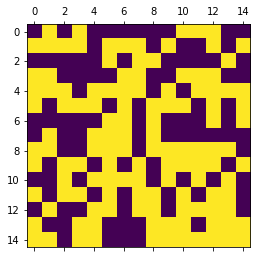

In [313]:
θ = {doc:np.random.choice([0,1],size=15).tolist() for doc in D}
plt.matshow(list(θ.values()))

### ***2. 반복: ${\boldsymbol \theta}_0 \to {\boldsymbol \theta}_1 \to {\boldsymbol \theta}_2 \to \dots$***

In [314]:
for t in range(5):
    for doc in D:
        for i, wrd in enumerate(D[doc]):
            # 임시의 data를 만들고 현재 포커싱되어있는 자료를 삭제함 
            data = {'D':copy.deepcopy(D), 'θ': copy.deepcopy(θ)} 
            del data['D'][doc][i]
            del data['θ'][doc][i]
            
            # 토픽의 타당성조사, msr는 타당성을 나타내는 측도, prob는 msr의 총합을 1로 맞춤
            msr0 = p1(topic=0, doc=doc, data=data) * p2(word=wrd, topic=0, data=data) # 토픽0의 타당성
            msr1 = p1(topic=1, doc=doc, data=data) * p2(word=wrd, topic=1, data=data) # 토픽1의 타당성
            prob = [msr0/(msr0 + msr1), msr1/(msr0 + msr1)] 
            
            # update θ|
            θ[doc][i] = np.random.choice([0,1], p=prob)            

## 시각화

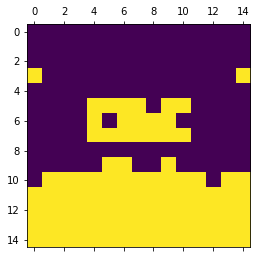

In [315]:
plt.matshow(list(θ.values()))